In [1]:

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from torch.nn import functional as F

import time
import math

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# print pytorch version
print(torch.__version__)

EXPERIMENT_ID = '6_5'
device

2.2.0


device(type='cpu')

In [3]:
def create_data_loader(batch_size):
  # Split the provided CIFAR-10 train set (50,000 images) into your train and val sets
  # Use the first 40,000 images as your train set and the remaining 10,000 images as val set
  # Use all 10,000 images in the provided test set as your test set

  transform = transforms.Compose([
    transforms.ToTensor(),
      # This is the mean and the average of the cifar db because we are normalizing it.
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)), 
  ])

  # load cifar
  train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
  test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  # split train set into train and val
  train_set, val_set = torch.utils.data.random_split(train_set, [40000, 10000])

  # create data loaders
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=4)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True,num_workers=4)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True,num_workers=4)

  train_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in train_loader]
  val_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in val_loader]
  test_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in test_loader]


  return train_loader, val_loader, test_loader

In [4]:
class CustomConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(CustomConv2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # Initialize weights and biases
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.randn(out_channels))

    def forward(self, x):
        # Add padding if necessary
        if self.padding > 0:
            x = torch.nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))
        
        batch_size, in_channels, input_height, input_width = x.size()
        
        # Calculate the dimensions of the output tensor
        output_height = (input_height - self.kernel_size) // self.stride + 1
        output_width = (input_width - self.kernel_size) // self.stride + 1
        
        # Initialize the output tensor
        output = torch.zeros((batch_size, self.out_channels, output_height, output_width))
        
        for b in range(batch_size):
            for o in range(self.out_channels):
                for i in range(0, output_height * self.stride, self.stride):
                    for j in range(0, output_width * self.stride, self.stride):
                        region = x[b, :, i:i+self.kernel_size, j:j+self.kernel_size]
                        output[b, o, i//self.stride, j//self.stride] = torch.sum(region * self.weight[o]) + self.bias[o]
        
        return output




class AddEpsilon(nn.Module):
    def __init__(self, epsilon=1e-10): # 1e-10 is smallest possible float in pytorch
        super().__init__()
        self.epsilon = epsilon

    def forward(self, x):
        return x + self.epsilon

    

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def init_train_var(model):
  
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.2 ) # set momentum to 0.2 after trial and error

  return criterion, optimizer

In [6]:
def test(model_path, test_loader):
  # use the provided test loader
  # return the test accuracy
  model = torch.load(model_path)
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    test_acc = correct / total
  return test_acc


In [7]:
BATCH_SIZE = 1024
train_loader, val_loader, test_loader = create_data_loader(batch_size=BATCH_SIZE)


model = Net()
model = torch.compile(model)
model = model.to(device)
# model = nn.DataParallel(model)
criterion, optimizer = init_train_var(model)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
EPOCH_COUNT = 800

In [9]:
%%time

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(EPOCH_COUNT):
    model.train()
    train_loss = 0
    train_correct = 0
    # for each batch
    for i, (inputs, labels) in enumerate(train_loader):
        # count the number of weights with very small magnitute < 1e-3
        nans_count = 0
        for param in model.parameters():
            if param.grad is not None:
                nans_count += torch.sum(torch.isnan(param.grad)).item()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print all gradients of the first synapse
        # print(f"synapse grads : {model.classifier[-1].synapses[0][0].main[0].grad}")
        # print(f"weights of first layer {model.classifier[-1].synapses[0][0]}")
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()


    print(f'Epoch {epoch+1}/{EPOCH_COUNT}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_correct/40000:.4f}')
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct/40000)

    # validate
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
    val_acc = val_correct/10000
    print(f'Epoch {epoch+1}/{EPOCH_COUNT}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    



Epoch 1/800, Train Loss: 92.2147, Train Accuracy: 0.0992
Epoch 1/800, Val Loss: 23.0547, Val Accuracy: 0.0994
Epoch 2/800, Train Loss: 92.1768, Train Accuracy: 0.0998
Epoch 2/800, Val Loss: 23.0457, Val Accuracy: 0.0998
Epoch 3/800, Train Loss: 92.1406, Train Accuracy: 0.0996
Epoch 3/800, Val Loss: 23.0369, Val Accuracy: 0.0998
Epoch 4/800, Train Loss: 92.1048, Train Accuracy: 0.0998
Epoch 4/800, Val Loss: 23.0280, Val Accuracy: 0.1005
Epoch 5/800, Train Loss: 92.0683, Train Accuracy: 0.1000
Epoch 5/800, Val Loss: 23.0188, Val Accuracy: 0.1003
Epoch 6/800, Train Loss: 92.0303, Train Accuracy: 0.1003
Epoch 6/800, Val Loss: 23.0092, Val Accuracy: 0.1000
Epoch 7/800, Train Loss: 91.9903, Train Accuracy: 0.1010
Epoch 7/800, Val Loss: 22.9989, Val Accuracy: 0.1005
Epoch 8/800, Train Loss: 91.9475, Train Accuracy: 0.1018
Epoch 8/800, Val Loss: 22.9878, Val Accuracy: 0.1007
Epoch 9/800, Train Loss: 91.9007, Train Accuracy: 0.1036
Epoch 9/800, Val Loss: 22.9756, Val Accuracy: 0.1022
Epoch 10/8

KeyboardInterrupt: 

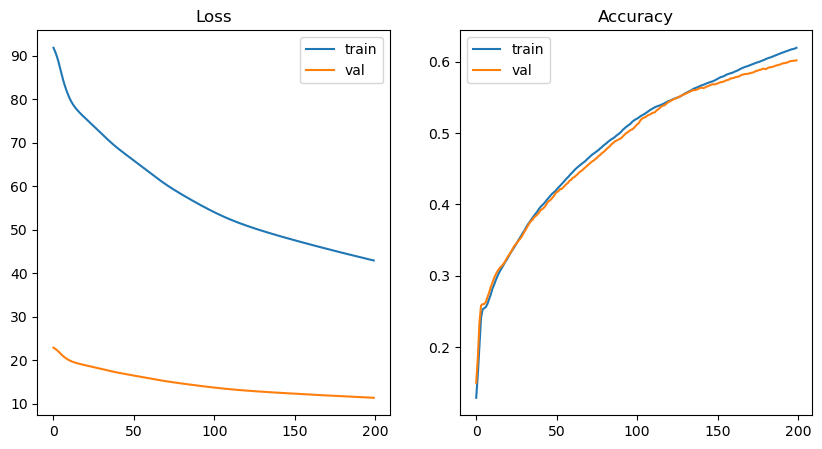

In [ ]:
# plot the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='val')
plt.title('Accuracy')
plt.legend()


# save plot to storage
plt.savefig(f"experiment_{EXPERIMENT_ID}_plot.png")

plt.show()

# save model to storage
torch.save(model, f"experiment_{EXPERIMENT_ID}_model.pth")

In [ ]:
# print weights and powers of quasi poly layer

quasi_poly_layer = model.classifier[-1]
for i in range(quasi_poly_layer.out_features):
    for j in range(quasi_poly_layer.in_features):
        print(f'QuasiPolySynapse {i} {j} power: {quasi_poly_layer.synapses[i][j].power.item()}')
        print(f'QuasiPolySynapse {i} {j} term weights: {quasi_poly_layer.synapses[i][j].term_weights.data}')
        



AttributeError: 'Linear' object has no attribute 'synapses'